# SSC_ATACseq_Analysis.Pipeline.AllSamples


In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
import matplotlib as mpl
from itertools import groupby
import math
import scipy.stats
from scipy.stats.mstats import gmean
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import pearsonr
import random
import itertools


In [156]:

#Functions
def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)

def Read(File):
    return pd.read_table(File,sep='\t',index_col=0)

def ReadBed(File):
    Bed=pd.read_table(File,sep='\t',index_col=None,header=None)
    Bed.index=Bed[3]
    return Bed

def Save(DF,File):
    DF.to_csv(File,sep='\t')

def SaveBed(Bed,File):
    Bed.to_csv(File,sep='\t',index=False,header=False)
    
def GetState(i):
    if 'Norm' in i: return 'Norm'
    if 'Arm' in i: return 'Arm'
    if 'Back' in i:return 'Back'

def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def SizeFactor(DF):return (DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)

def Ttest1(A,B,Index_List):
    return pd.Series(scipy.stats.ttest_ind(A,B,axis=1)[1],index=Index_List)

def Ttest(A,B,Index_List):
    P=[]
    for i in Index_List:
        _,p=scipy.stats.ttest_ind(list(A.loc[i].dropna()),list(B.loc[i].dropna()))
        P.append(p)
    return pd.Series(P,index=Index_List)


def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

    
# input A/B is a DataFrame(log2)
def Diff_FDR(A,B,fdc,fdr):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    FDR=pd.Series(p_adjust_bh(Pval.values), index=Indexs)
    return FDC,FDR,list(A2[(FDC>fdc)&(FDR<fdr)].index),list(A2[(FDC<-fdc)&(FDR<fdr)].index)
    

def Diff_Pval(A,B,fdc,p):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))           
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    return FDC,Pval,list(A2[(FDC>fdc)&(Pval<p)].index),list(A2[(FDC<-fdc)&(Pval<p)].index)
    
    

In [157]:
#Inputfiles
AllF='./SourceData/atac.count'                                             
AllCommonF='./SourceData/NormSSc.raw.order.txt'
NormF='./SourceData/NormSkin.raw.txt'
ArmF='./SourceData/SSC_Arm_raw.txt'
BackF='./SourceData/SSC_Back_raw.txt'

AllBed='./SourceData/atac.merged.peak.list'
AllCommonBed='./SourceData/NormSScPeaks.bed'
NormBed='./SourceData/NormSkinPeaks.bed'

#Output Dir
outDir="./Output"
outDirAll="./Output/All"
outDirNorm="./Output/Norm"
outDirAllCommon="./Output/AllSamples_NormSScCommon"
map(Mkdir,[outDir,outDirAll,outDirNorm,outDirAllCommon])



[None, None, None, None]

In [9]:
#Color
ClusterColorsDict={'CD4':'#EC2427','CD8':'#F15E25','Mac':'#231F20','Fib':'#3B54A4','EC':'#EB0D8C','DC':'#6CBE46','LC':'#34C5F4','KC':'#F6EC13','CD31':'#EB0D8C'}          
ClusterMarkerDict={'Norm':'o','Back':'^','Arm':'s'}
StateColorDict={'Norm':'#1B5B9C','Arm':'#C94540','Back':'coral','Norm-Arm-Back':'#8B8C8F','Arm-Back':'#4D2A7C','Norm-Arm':'#675EA9','Norm-Back':'#4B86C6'} 




# Replicates Plot

In [23]:
Dir=os.path.join(outDirNorm, 'Replicates')
Mkdir(Dir)


In [24]:
def NormLog(DF,label,method,O,outDir):
    def log(L):return np.array([math.log(i+1,2) for i in L])
    if method=='QNorm':
        print 'Do QNorm...'
        rank_mean=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
        DF=DF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
        print 'QNorm Done!'
    if method=='DEseq':
        print 'Do DEseq...'
        SizeFactor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
        DF=DF/SizeFactor
        outSizeFactor=os.path.join(outDir,'DEseq_sizeFactors.txt')
        SizeFactor.to_csv(outSizeFactor,sep='\t')
        print 'DEseq Done!'
    DFlog=DF.apply(log)
    if O:
        print 'Output file...'
        outfilelog=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.log2.txt')
        outfile=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.txt')
        DF.to_csv(outfile,sep='\t')
        DFlog.to_csv(outfilelog,sep='\t')
    return DF,DFlog


df=ReadTable(NormF)             
Alldf_Norm,Alldf_Normlog=NormLog(df,'','QNorm',False,None)




Do QNorm...
QNorm Done!


In [29]:
def RepPlot(DF,X,Y,Dir):
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_axes([0.15,0.15,0.8,0.8])
    ax.hist2d(DF[X],DF[Y],bins=300,cmin=1, cmax=10000,vmin=1,vmax=15,cmap='magma')
    ax.set_ylabel(Y,fontsize=20)
    ax.set_xlabel(X,fontsize=20)
    ax.set_title(str(scipy.stats.pearsonr(df[X],df[Y])))   
    ax.tick_params(axis='y',length=0,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=0,labelsize=15,direction='out')
    ax.set_xlim(3,10)
    ax.set_ylim(3,10)
    fig.savefig(os.path.join(Dir,'RepPlot.{}-{}.pdf'.format(X,Y)))
    plt.show()
    

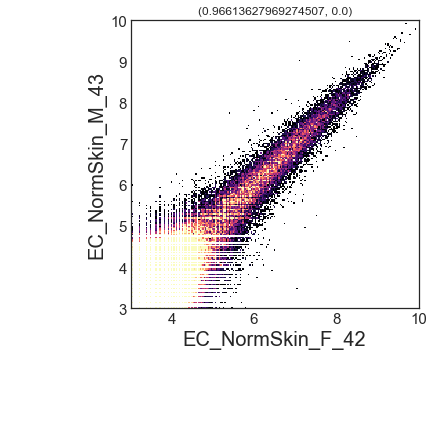

In [30]:

RepPlot(Alldf_Normlog,'EC_NormSkin_F_42','EC_NormSkin_M_43',Dir)



## QC Analysis

In [32]:

Dir=os.path.join('./SourceData','QC')
FragDir=os.path.join(Dir,'FragmentDistribution')
TSSDir=os.path.join(Dir,'TSS')


In [36]:
def get_Fig_ax(x_label,y_label):
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(6,5.0))
    ax=fig.add_axes([0.25,0.25,0.55,0.65])
    ax.tick_params(axis='y',length=7,labelsize=30,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=30,direction='out')
    ax.set_ylabel(y_label.capitalize(),fontsize=35)
    ax.set_xlabel(x_label.capitalize(),fontsize=35)
    if x_label=='length':
        ax.set_ylim([-0.0005,0.015])
    elif x_label=='center':
        ax.set_ylim([-1,22])
    return fig,ax

def get_interval(L):
    Int=scipy.stats.norm.interval(0.95,np.mean(L),np.std(L))
    return Int[0],Int[1]

def DrawQC(fig,ax,Xs,Ys,color):
    MeanY=[np.mean(i) for i in Ys]
    Int=[get_interval(i) for i in Ys]
    IntY1=[i[0] for i in Int]
    IntY2=[i[1] for i in Int]
    ax.fill_between(Xs,IntY1,IntY2,edgecolor='none',facecolor=color,alpha=0.2)
    ax.plot(Xs,MeanY,color=color,alpha=1,linewidth=1.5)

def GetQC(File,x_label,y_label):
    DF=ReadTable(File)
    fig,ax=get_Fig_ax(x_label,y_label)
    Xs=[]
    Ys=[]
    for x in sorted(list(set(DF[x_label]))):
        Xs.append(x)
        Ys.append(list(DF[DF[x_label]==x][y_label]))
    return Xs,Ys


    
    

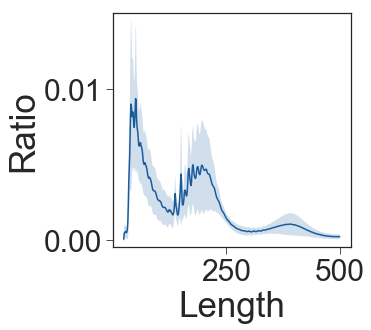

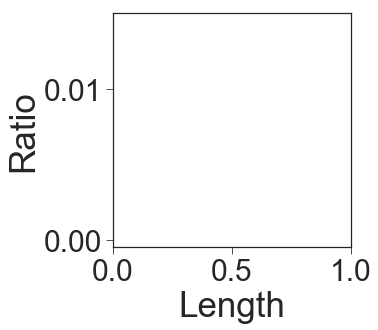

In [37]:
fig1,ax1=get_Fig_ax('length','ratio')
Xs_Norm,Ys_Norm=GetQC(os.path.join(FragDir,'Fragmentdistribution.Norm.txt'),'length','ratio')
DrawQC(fig1,ax1,Xs_Norm,Ys_Norm,'#1B5B9C')
fig1.savefig(os.path.join(FragDir, 'Fragmentdistribution.NormSamples.pdf'))
plt.show()



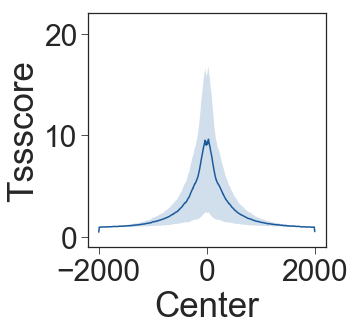

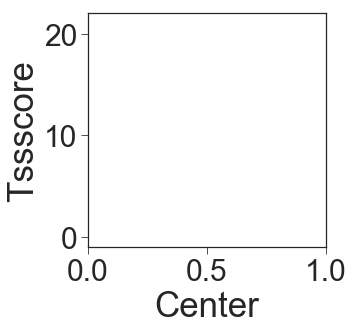

In [38]:
fig2,ax2=get_Fig_ax('center','TSSscore')
Xs_Norm,Ys_Norm=GetQC(os.path.join(TSSDir,'TSSscore.Norm.txt'),'center','TSSscore')
DrawQC(fig2,ax2,Xs_Norm,Ys_Norm,'#1B5B9C')
fig2.savefig(os.path.join(TSSDir, 'TSSscore.NormSamples.pdf'))
plt.show()


# Normalization

In [10]:
def NormLog(DF,label,method,O,outDir):
    def log(L):return np.array([math.log(i+1,2) for i in L])
    if method=='QNorm':
        print 'Do QNorm...'
        rank_mean=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
        DF=DF.rank(method='min').stack().astype(int).map(rank_mean).unstack()
        print 'QNorm Done!'
    if method=='DEseq':
        print 'Do DEseq...'
        SizeFactor=(DF.T/DF.apply(gmean,axis=1)).dropna(axis=1,how='any').apply(np.median,axis=1)
        DF=DF/SizeFactor
        outSizeFactor=os.path.join(outDir,'DEseq_sizeFactors.txt')
        SizeFactor.to_csv(outSizeFactor,sep='\t')
        print 'DEseq Done!'
    DFlog=DF.apply(log)
    if O:
        print 'Output file...'
        outfilelog=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.log2.txt')
        outfile=os.path.join(outDir,'PeakCount.'+label+'_'+method+'_Normalized.txt')
        DF.to_csv(outfile,sep='\t')
        DFlog.to_csv(outfilelog,sep='\t')
    return DF,DFlog


In [11]:
NormDF=Read(NormF)
NormDF_Norm,NormDF_Normlog=NormLog(NormDF,'NormSkin','QNorm',True,outDirNorm)


Do QNorm...
QNorm Done!
Output file...


In [12]:
AllDF=Read(AllF)
AllDF_Norm,AllDF_Normlog=NormLog(AllDF,'AllSampleSkin','QNorm',True,outDirAll)


Do QNorm...
QNorm Done!
Output file...


In [ ]:
AllCommonDF=Read(AllCommonF)
AllCommonDF_Norm,AllCommonDF_Normlog=NormLog(AllCommonDF,'AllSampleSkin','QNorm',True,outDirAllCommon)


# Sample ColorAnnotation

In [13]:

AllSampleColorDF=pd.DataFrame({'Celltype':[ClusterColorsDict[i.split('_')[0]] for i in list(AllDF)]}, index=list(AllDF))              
AllSampleColorDF['State']=[StateColorDict[GetState(i)] for i in AllSampleColorDF.index]



# Annotation Peaks

In [14]:
NormAnoF=os.path.join(outDirNorm,'NormPeaks.ano.txt')
Comd='annotatePeaks.pl {} hg19 > {}'.format(NormBed,NormAnoF)
os.system(Comd)


0

In [15]:
AllAnoF=os.path.join(outDirAll,'AllSamplesPeaks.ano.txt')
Comd='annotatePeaks.pl {} hg19 > {}'.format(AllBed,AllAnoF)
os.system(Comd)



0

In [ ]:
AllCommonAnoF=os.path.join(outDirAll,'NormSScPeaks.bed.ano.txt')
Comd='annotatePeaks.pl {} hg19 > {}'.format(AllCommonBed,AllCommonAnoF)
os.system(Comd)



### Correlation Annalysis

In [149]:
NormAnoDF=ReadTable(NormAnoF)
AllAnoDF=ReadTable(AllAnoF)


In [ ]:
DirNorm=os.path.join(outDirNorm,'SampleCorrelation')
DirAll=os.path.join(outDirAll,'SampleCorrelation')
Mkdir(DirNorm)
Mkdir(DirAll)


In [31]:
NormDF_Norm_Distal=NormDF_Norm.loc[NormAnoDF[abs(NormAnoDF['Distance to TSS'])>1000].index]
AllDF_Norm_Distal=AllDF_Norm.loc[AllAnoDF[abs(AllAnoDF['Distance to TSS'])>1000].index]


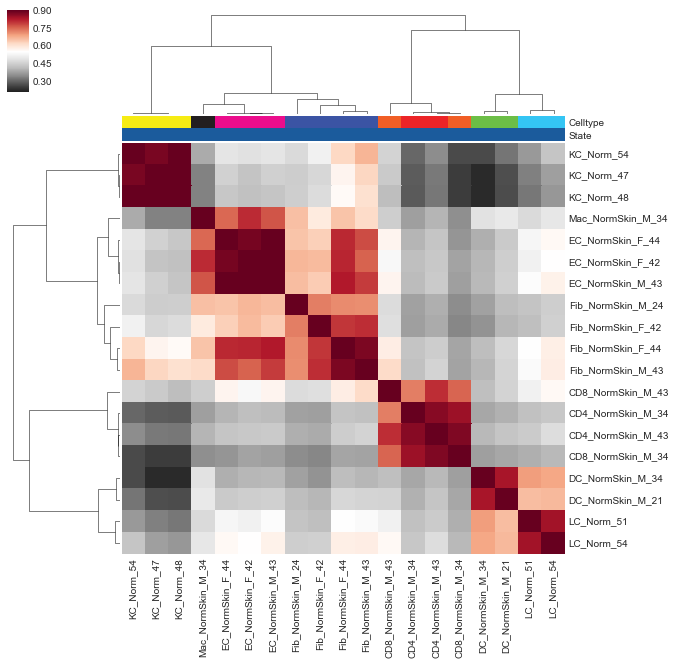

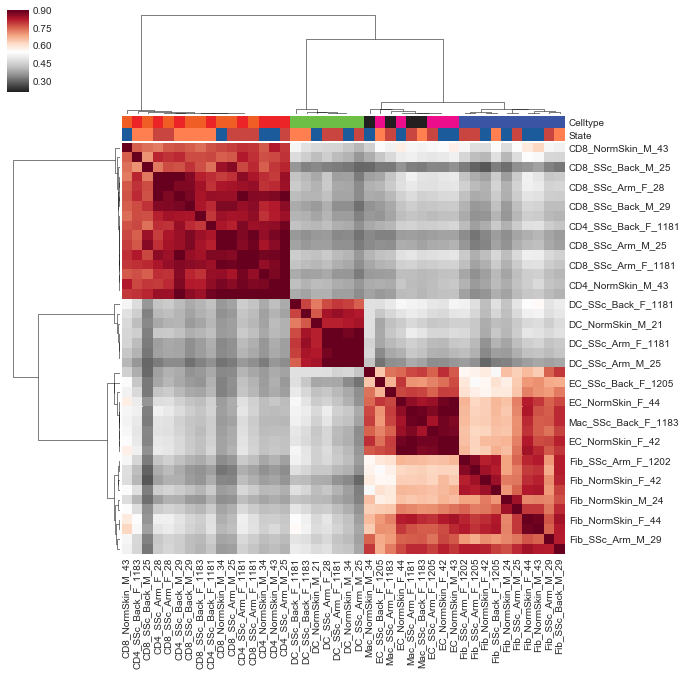

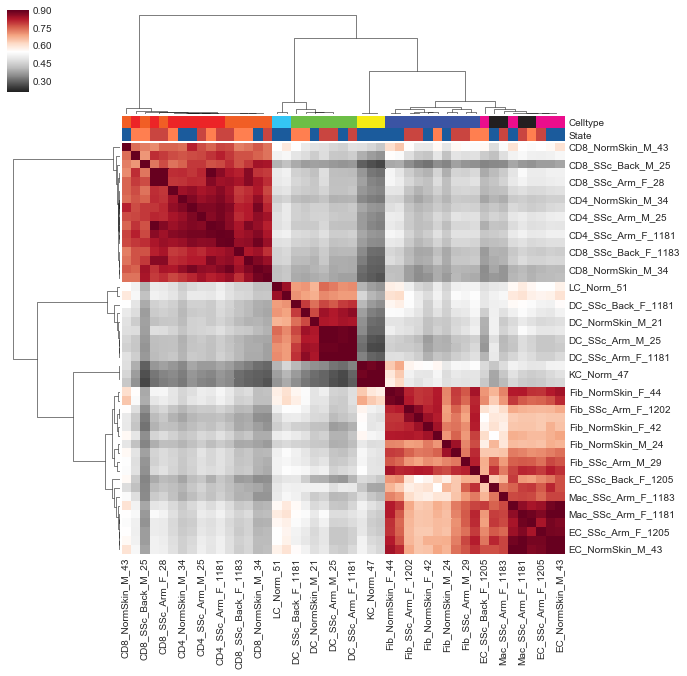

In [32]:

CorDF=NormDF_Norm_Distal.corr(method='pearson')
sns.clustermap(CorDF,cmap='RdGy_r',method='average', metric='correlation',vmax=0.9,vmin=0.2, col_colors=AllSampleColorDF)                 
plt.savefig(os.path.join(DirNorm,"DistalPeaks_NormSample_Correlation.pdf"))
plt.show()
Save(CorDF, os.path.join(DirNorm,'DistalPeaks_NormSample_PearsonCorrelation.txt'))

AllCorDF=AllDF_Norm_Distal.corr(method='pearson')
sns.clustermap(AllCorDF,cmap='RdGy_r',method='average', metric='correlation',vmax=0.9,vmin=0.2, col_colors=AllSampleColorDF)                 
plt.savefig(os.path.join(DirAll,"DistalPeaks_AllSample_Correlation.pdf"))
plt.show()
Save(CorDF, os.path.join(DirAll,'DistalPeaks_AllSample_PearsonCorrelation.txt'))



# Celltype specific Peaks

In [16]:

DirNorm=os.path.join(outDirNorm,'SampleCelltypeSpecific')
DirAll=os.path.join(outDirAll,'SampleCelltypeSpecific')
Mkdir(DirNorm)
Mkdir(DirAll)



In [17]:

#Celltype specific peaks selection
def CellTypeSpecificPeaks(DF,label,Bed,Order,outDir,ColorDF,cmap='YlGnBu',incov=0.5,outcov=0.5,f=1.5,p=0.01,DoNorm=True):
    Dir=os.path.join(outDir,'SpecificPeaks.incov_{}.outcov_{}.f_{}.p_{}'.format(incov,outcov,f,p))
    Mkdir(Dir)
    SampleUsed=[i for i in list(DF) if i.split('_')[0] in Order]
    DF=DF[SampleUsed]
    if DoNorm:
        NormDF,NormDFLog=NormLog(DF,label,'QNorm',True,outDir)
    else:
        NormDFLog=DF
    NormDFLog=NormDFLog[NormDFLog.apply(max,axis=1)>4]
    PEAK=[]
    SAMPLE=[]
    CellTypeSpecificPeaks_Dict={}
    for ct in Order:
        print ct
        CT=ct.split('-')
        IN=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] in CT]]
        if len(CT)==1:
            SAMPLE=SAMPLE+list(IN)
        OUT=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] not in CT]]
        outCOV=OUT.apply(scipy.stats.variation,axis=1)
        M=IN.apply(np.mean,axis=1)
        F=M-OUT.apply(np.mean,axis=1)
        
        if ct=='Mac':
            continue
            
        if len(list(IN))>1:
            inCOV=IN.apply(scipy.stats.variation,axis=1)
            P=pd.Series(scipy.stats.ttest_ind(IN,OUT,axis=1)[1],index=IN.index)
            Peaks=list(M[(inCOV<incov)&(outCOV<outcov)&(F>f)&(P<p)].sort_values().index)
        elif len(list(IN))==1:
            Peaks=list(M[(outCOV<outcov)&(F>3)].sort_values().index)
        Data=NormDFLog.loc[Peaks]
        bed=Bed.loc[Peaks]
        Save(Data,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.txt'))
        SaveBed(bed,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.bed'))
        Peaks=[i for i in Peaks if i not in PEAK]
        print len(Peaks)
        CellTypeSpecificPeaks_Dict[ct]=Peaks
        PEAK=PEAK+Peaks
        
    DATA=NormDFLog[SAMPLE].loc[PEAK]
    BED=Bed.loc[PEAK]
    Save(DATA,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.txt'))
    SaveBed(BED,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.bed'))
    #ColorDF=pd.DataFrame({'CellType':[ClusterColorsDict[i.split('_')[0]] for i in SAMPLE]},index=SAMPLE)
    print 'Draw Figure ...'
    DATA.index=[' ']*len(DATA)
    fig=sns.clustermap(DATA,figsize=(6,6),row_cluster=False,col_cluster=False,cmap=cmap,vmin=2,vmax=8,xticklabels=[i.split('_')[0] for i in SAMPLE],col_colors=ColorDF)
    print 'Save Figure ...'
    fig.savefig(os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf'))
    print os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf')
    plt.show()
    print 'Done!'   
    return CellTypeSpecificPeaks_Dict



Do QNorm...
QNorm Done!
Output file...
CD4
828
CD4-CD8
2963
CD8
121
DC
1986
DC-LC
2896
LC
497
Fib
1089
EC
370
Mac
KC
3493
Draw Figure ...
Save Figure ...
/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_AllCelltype_AllClinicalState/Without_Macrophage_And_Mac/Replicates/SpecificPeaks.incov_0.5.outcov_0.5.f_2.p_0.005/Celltype.specific.Peaks.QNorm.log.pdf


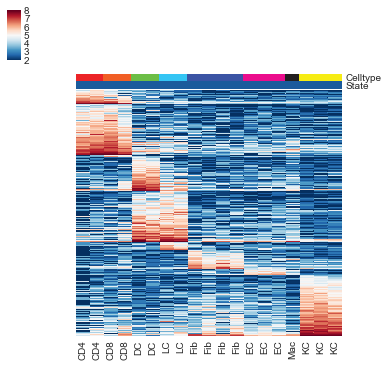

Done!


In [74]:
#Norm
NBed=ReadBed(NormBed)
NormDF=Read(NormF)
NormOrder=['CD4','CD4-CD8','CD8','DC','DC-LC','LC','Fib','EC','Mac','KC']
NormCellTypeSpecificPeaks_Dict=CellTypeSpecificPeaks(NormDF,'Norm',NBed,NormOrder,DirNorm,AllSampleColorDF,cmap='RdBu_r',incov=0.5,outcov=0.5,f=2,p=0.005,DoNorm=True)    



In [20]:
#AllSamples
#Celltype specific peaks selection
def CellTypeSpecificPeaks_WithoutMac_AddMacSpecific(DF,label,Bed,Order,outDir,ColorDF,cmap='YlGnBu',incov=0.5,outcov=0.5,f=1.5,p=0.01,DoNorm=True):
    Dir=os.path.join(outDir,'SpecificPeaks.incov_{}.outcov_{}.f_{}.p_{}'.format(incov,outcov,f,p))
    Mkdir(Dir)
    
    def CellTypeSpecific(NormDFLog, CT,CellTypeSpecificPeaks_Dict,PEAK,Dir,ct):
        IN=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] in CT]]
        OUT=NormDFLog[[i for i in list(NormDFLog) if i.split('_')[0] not in CT]]
        outCOV=OUT.apply(scipy.stats.variation,axis=1)
        M=IN.apply(np.mean,axis=1)
        F=M-OUT.apply(np.mean,axis=1)
        if len(list(IN))>1:
            inCOV=IN.apply(scipy.stats.variation,axis=1)
            P=pd.Series(scipy.stats.ttest_ind(IN,OUT,axis=1)[1],index=IN.index)
            Peaks=list(M[(inCOV<incov)&(outCOV<outcov)&(F>f)&(P<p)].sort_values().index)
        elif len(list(IN))==1:
            return []
        Data=NormDFLog.loc[Peaks]
        bed=Bed.loc[Peaks]
        Save(Data,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.txt'))
        SaveBed(bed,os.path.join(Dir,ct+'.specific.Peaks.QNorm.log.bed'))
        Peaks=[i for i in Peaks if i not in PEAK]
        print len(Peaks)
        CellTypeSpecificPeaks_Dict[ct]=Peaks
        return Peaks
    
    #Specific Peaks for Other celltypes
    SampleUsed=[i for i in list(DF) if i.split('_')[0] in [x for x in Order if x!='Mac']]
    NormDF,NormDFLog=NormLog(DF[SampleUsed],label,'QNorm',True,outDir)
    NormDFLog=NormDFLog[NormDFLog.apply(max,axis=1)>4]
    PEAK=[]
    SAMPLE=[]
    CellTypeSpecificPeaks_Dict={}
    for ct in Order:
        print ct
        CT=ct.split('-')
        if len(CT)==1:
            SAMPLE=SAMPLE+list([i for i in list(DF) if i.split('_')[0] in CT])
        if ct!='Mac':
            Peaks=CellTypeSpecific(NormDFLog, CT,CellTypeSpecificPeaks_Dict,PEAK,Dir,ct)
        if ct=='Mac':
            _,NormDFLogAll=NormLog(DF,label,'QNorm',True,outDir)
            Peaks=CellTypeSpecific(NormDFLogAll, CT,CellTypeSpecificPeaks_Dict,PEAK,Dir,ct)
        PEAK=PEAK+Peaks
            
    print SAMPLE
    NormDF,NormDFLog=NormLog(DF,label,'QNorm',True,outDir)
    DATA=NormDFLog[SAMPLE].loc[PEAK]
    BED=Bed.loc[PEAK]
    Save(DATA,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.txt'))
    SaveBed(BED,os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.bed'))
    #ColorDF=pd.DataFrame({'CellType':[ClusterColorsDict[i.split('_')[0]] for i in SAMPLE]},index=SAMPLE)
    print 'Draw Figure ...'
    DATA.index=[' ']*len(DATA)
    fig=sns.clustermap(DATA,figsize=(6,6),row_cluster=False,col_cluster=False,cmap=cmap,vmin=2,vmax=8,xticklabels=[i.split('_')[0] for i in SAMPLE],col_colors=ColorDF)
    print 'Save Figure ...'
    fig.savefig(os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf'))
    print os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.pdf')
    plt.show()
    print 'Done!'   
    
    fig=sns.clustermap(DATA.apply(scipy.stats.zscore,axis=1),figsize=(6,6),row_cluster=False,col_cluster=False,cmap=cmap,vmin=-2,vmax=2,xticklabels=[i.split('_')[0] for i in SAMPLE],col_colors=ColorDF)
    print 'Save Figure ...'
    fig.savefig(os.path.join(Dir,'Celltype.specific.Peaks.QNorm.log.Zscore.pdf'))
    plt.show()
    return CellTypeSpecificPeaks_Dict



Do QNorm...
QNorm Done!
Output file...
CD4


/Users/liuqian/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:977: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


2597
CD4-CD8
2939
CD8
259
DC
3183
DC-LC
589
LC
182
Mac
Do QNorm...
QNorm Done!
Output file...
284
EC
941
Fib
1583
KC
1884
['CD4_NormSkin_M_34', 'CD4_NormSkin_M_43', 'CD4_SSc_Arm_F_1181', 'CD4_SSc_Arm_M_25', 'CD4_SSc_Back_F_1181', 'CD4_SSc_Back_F_1183', 'CD4_SSc_Arm_F_28', 'CD4_SSc_Back_M_29', 'CD8_NormSkin_M_34', 'CD8_NormSkin_M_43', 'CD8_SSc_Arm_F_1181', 'CD8_SSc_Arm_M_25', 'CD8_SSc_Back_F_1183', 'CD8_SSc_Back_M_25', 'CD8_SSc_Arm_F_28', 'CD8_SSc_Back_M_29', 'DC_NormSkin_M_21', 'DC_NormSkin_M_34', 'DC_SSc_Arm_F_1181', 'DC_SSc_Arm_F_28', 'DC_SSc_Arm_M_25', 'DC_SSc_Back_F_1181', 'DC_SSc_Back_F_1183', 'LC_Norm_51', 'LC_Norm_54', 'Mac_NormSkin_M_34', 'Mac_SSc_Arm_F_1181', 'Mac_SSc_Arm_F_1183', 'Mac_SSc_Back_F_1183', 'EC_NormSkin_F_42', 'EC_NormSkin_F_44', 'EC_NormSkin_M_43', 'EC_SSc_Arm_F_1205', 'EC_SSc_Back_F_1205', 'Fib_NormSkin_F_42', 'Fib_NormSkin_F_44', 'Fib_NormSkin_M_24', 'Fib_NormSkin_M_43', 'Fib_SSc_Arm_F_1202', 'Fib_SSc_Arm_F_1205', 'Fib_SSc_Arm_M_25', 'Fib_SSc_Arm_M_29', 'Fib_SS

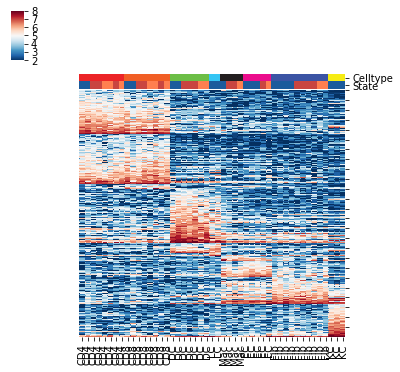

Done!
Save Figure ...


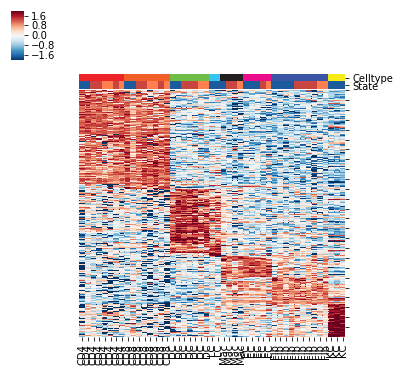

In [21]:

DirAll3=os.path.join(outDirAll,'SampleCelltypeSpecific_AddMacSpecific')
Mkdir(DirAll3)
AllBedDF=ReadBed(AllBed)
AllOrder=['CD4','CD4-CD8','CD8','DC','DC-LC','LC','Mac','EC','Fib','KC']
AllCellTypeSpecificPeaks_Dict=CellTypeSpecificPeaks_WithoutMac_AddMacSpecific(AllDF,'AllSamples',AllBedDF,AllOrder,DirAll3,AllSampleColorDF,cmap='RdBu_r',incov=0.5,outcov=0.5,f=1.5,p=0.005,DoNorm=True)    




In [30]:
DirAll3

'/Users/liuqian/Documents/A_SSC_project/A_Code_available/AllSamples_AllCelltype_AllClinicalState/Without_Macrophage_And_Mac/SampleCelltypeSpecific_WithoutMac_AddMacSpecific'

# Ano Bed

In [32]:
#Input Dirs

def AnoBed(Dir):
    BedFiles=[i for i in os.listdir(Dir) if i[-3:]=='bed']
    for f in BedFiles:
        print f
        F=os.path.join(Dir,f)
        comd='/seq/homer/bin/annotatePeaks.pl {} hg19 > {}.ano.txt'.format(F,F)
        os.system(comd)
    
    

In [33]:
AnoBed(os.path.join(DirAll3,'SpecificPeaks.incov_0.5.outcov_0.5.f_1.5.p_0.005'))                           




CD4-CD8.specific.Peaks.QNorm.log.bed
CD4.specific.Peaks.QNorm.log.bed
CD8.specific.Peaks.QNorm.log.bed
Celltype.specific.Peaks.QNorm.log.bed
DC-LC.specific.Peaks.QNorm.log.bed
DC.specific.Peaks.QNorm.log.bed
EC.specific.Peaks.QNorm.log.bed
Fib.specific.Peaks.QNorm.log.bed
KC.specific.Peaks.QNorm.log.bed
LC.specific.Peaks.QNorm.log.bed
Mac.specific.Peaks.QNorm.log.bed


# Genomica TF Enrichment 

In [34]:
AllGxrDir='./SourceDataSourceData/Genomica'


In [36]:

def Range(L):return max(L)-min(L)
def Genomic_Display(GxrFile,Dir,colormap='RdBu_r',LabelDF=None,vmax=50,colorLabel=['CelltypeColor'],topNum=100):
    GXR=Read(GxrFile)
    F1=((abs(GXR)>0).apply(sum,axis=1))>len(list(GXR))*0.1  #只保留那些至少在十分之一的样本中存在富集指数的TF
    GXR=GXR[F1]
    Index=GXR.apply(Range,axis=1).sort_values()[-topNum:].index
    GXR=GXR.loc[Index]
    Motif=[i.split('(')[0].upper() for i in Index]
    GXR.index=Motif
    GXR=GXR[~GXR.index.duplicated(keep='first')]
    GXR.to_csv(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.txt'.format(str(topNum))),sep='\t')
    fig=sns.clustermap(GXR,figsize=(0.3*len(list(GXR)),0.25*len(GXR)),center=0,vmin=-vmax,vmax=vmax,col_cluster=True,row_cluster=True,col_colors=LabelDF[colorLabel],cmap=colormap,method='average',metric='correlation')                    
    TFOrder=GXR.index[fig.dendrogram_row.reordered_ind]
    SamplesOrder=GXR.columns[fig.dendrogram_col.reordered_ind]
    
    plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0,fontsize=10)
    plt.setp(fig.ax_heatmap.get_xticklabels(), rotation=90,fontsize=10)
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Heatmap.pdf'.format(str(topNum))))
    
    
    oGXR=GXR.loc[TFOrder][SamplesOrder]
    
    y=[0.5+i for i in range(len(oGXR))]
    x=[0.5+i for i in range(len(list(oGXR)))]
    Ylim=[0,y[-1]+0.5]
    Xlim=[0,x[-1]+0.5]
    X=[]
    Y=[]
    C=[]
    Header=list(oGXR)
    for i in range(len(list(oGXR))):
        Col=Header[i]
        C=C+list(oGXR[Col])
        X=X+[0.5+i]*len(oGXR)
        Y=Y+y

    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.35*len(list(oGXR)),0.28*len(oGXR)))
    ax=fig.add_axes([0.15,0.05,0.8,0.9])
    ax.set_xlim(Xlim)
    ax.set_ylim(Ylim)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(list(oGXR),rotation='vertical')
    ax.set_yticklabels(list(oGXR.index))
    ax.scatter(X,Y,c=C,cmap='coolwarm',s=300,vmax=vmax,vmin=-vmax)
    ax.tick_params(axis='y',length=7,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=15,direction='out')
   
    fig.savefig(os.path.join(Dir,'GenomicMotifEnrichment.topNum{}.Scatterplot.pdf'.format(str(topNum))))
    plt.show()
    return oGXR



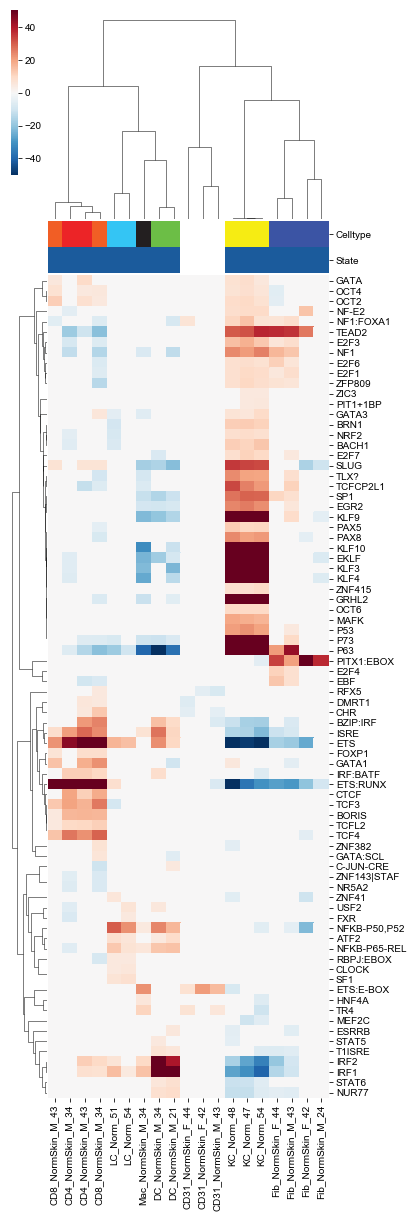

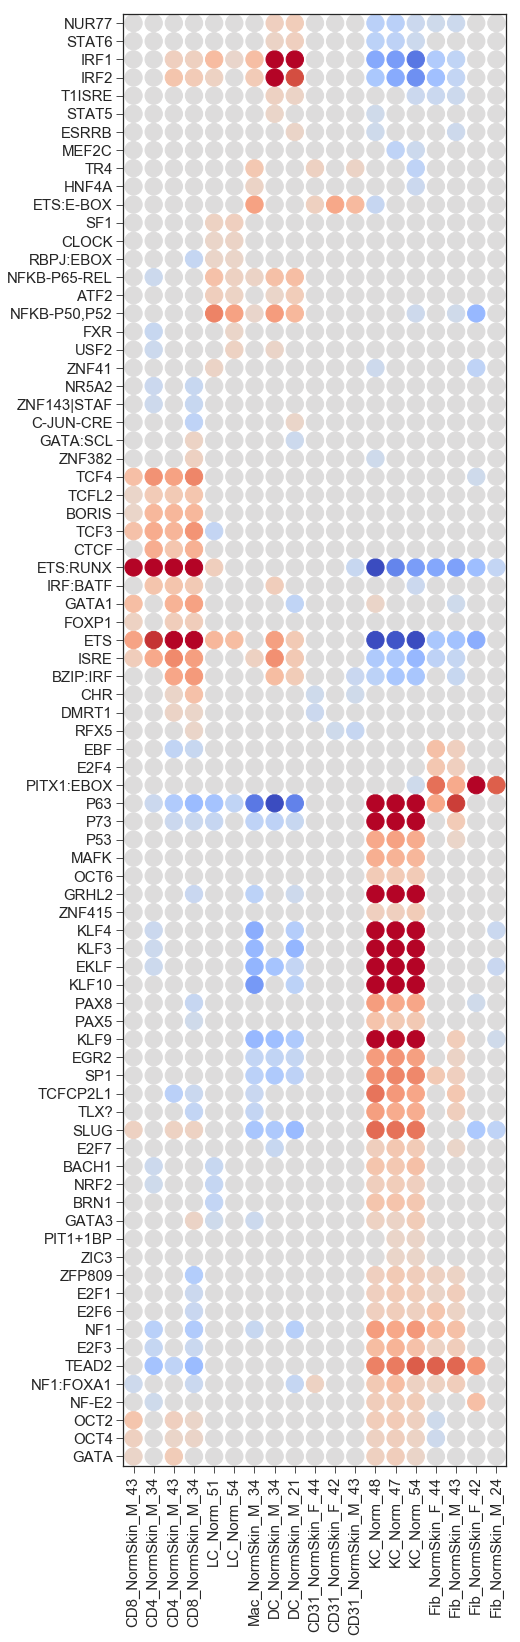

In [37]:
AllTFDF=Genomic_Display(os.path.join(AllGxrDir,'SpecificPeaks.gxr.txt'),AllGxrDir,colormap='RdBu_r',LabelDF=AllSampleColorDF,vmax=50,colorLabel=['Celltype','State'],topNum=150)                           



# with published data MRSS Correlation

### GSE76886

In [89]:

DirAll=os.path.join(outDirAll,'mRSSCorrelation_GSE76886')
Mkdir(DirAll)



In [90]:
#The mRSS Information was from the table(pdf format) of published paper(PMID: 23677167)
ExpDF=ReadTable("./SourceData/PublishedDataSets/GSE76886_ExpDF.txt")
ClinicalDF=ReadTable("./SourceData/PublishedDataSets/GSE76886_ClinicalDF.txt")
AnoDF=ReadTable("./SourceData/PublishedDataSets/GPL6480-9577.txt")    #PLease Download from GEO DataBase



In [91]:

ArrayRatio=((ExpDF>-1000000).apply(sum,axis=1)/len(list(ExpDF)))
ExpDF=ExpDF[(ExpDF.apply(np.max,axis=1)>0)&(ArrayRatio>0.8)]

FinalIndex=list(ClinicalDF[ClinicalDF['MRSS']>-1].index)
ExpDF=ExpDF[FinalIndex]
ClinicalDF=ClinicalDF.loc[FinalIndex]



In [92]:

MRSS_Inter=[]
for i in list(ClinicalDF['MRSS']):
    if 0<=i<=10:
        MRSS_Inter.append('0-10')
    elif 10<i<=20:
        MRSS_Inter.append('10-20')
    elif i>20:
        MRSS_Inter.append('20+')
ClinicalDF['MRSS_Inter']=MRSS_Inter



In [93]:
All_Oligo=[i for i in list(ExpDF.index) if i in list(AnoDF.index)]
ExpDF=ExpDF.loc[All_Oligo]


In [94]:

ClinicalDF['Time2']=[int(i.split('mo')[0]) if (i!='base') and (i!='Base') else 0 for i in list(ClinicalDF['Time'])]            
ClinicalDF['Samples']=[i.split('_')[1] for i in ClinicalDF.index]
ClinicalDF['Last']=[i.split('_')[-1] for i in ClinicalDF.index]
ClinicalDF['MRSS']=[int(i) for i in ClinicalDF['MRSS']]
ClinicalDF['State']=['SSc']*len(ClinicalDF)


In [113]:
ClinicalDF2=ClinicalDF[(ClinicalDF['Last']=='LA')|(ClinicalDF['Last']=='RA')]
def Range(L):return max(L)-min(L)
def Max(L):return max(L)
def Min(L):return min(L)
print ClinicalDF2.groupby('Patients')['MRSS'].apply(Range)
print ClinicalDF2.groupby('Patients')['MRSS'].apply(Max)
print ClinicalDF2.groupby('Patients')['MRSS'].apply(Range)/ClinicalDF2.groupby('Patients')['MRSS'].apply(Min)
Improver=[3,4,5,6,10,16,17,21,30,33,37,42,45] #N2 Ratio>5 LA&RA


Patients
3     17
4      6
5     11
6     11
7      1
8      3
10     6
12     5
13     0
15     5
16    17
17    20
20     4
21    11
23     3
25     5
28     4
30    13
31     0
32     2
33     6
35     4
36     0
37     9
38     0
41     0
42    10
44     2
45     7
47     1
Name: MRSS, dtype: int64
Patients
3     21
4      9
5     32
6     20
7      4
8     12
10    13
12    17
13    17
15    41
16    20
17    35
20    16
21    12
23     7
25    11
28    11
30    17
31    15
32     3
33    11
35     7
36     0
37    13
38    15
41     3
42    16
44    12
45    18
47    15
Name: MRSS, dtype: int64
Patients
3      4.250000
4      2.000000
5      0.523810
6      1.222222
7      0.333333
8      0.333333
10     0.857143
12     0.416667
13     0.000000
15     0.138889
16     5.666667
17     1.333333
20     0.333333
21    11.000000
23     0.750000
25     0.833333
28     0.571429
30     3.250000
31     0.000000
32     2.000000
33     1.200000
35     1.333333
36          NaN
37     2.250000

## MMF Response Genes 

In [96]:
#Affected skin
Before=ClinicalDF[(ClinicalDF['Time2']==0) &(ClinicalDF['Last']=='LA')]
After=ClinicalDF[((ClinicalDF['Time2']==24)|(ClinicalDF['Time2']==12)) & (ClinicalDF['Last']=='LA')]              
BExp=ExpDF[list(Before.index)]
AExp=ExpDF[list(After.index)]
Diff_Affected,Pval_Affected,_,_=Diff_FDR(AExp,BExp,1,0.05)




In [97]:
AllDiffProbs=list(BExp[(abs(Diff_Affected)>0.1)&(Pval_Affected<0.1)].index)
ResponseGenes=AnoDF.loc[AllDiffProbs]['GENE_SYMBOL'].dropna()


/Users/liuqian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [98]:
Save(ResponseGenes, os.path.join(DirAll,'MMF_ResponseGenes.txt'))


## Signature Genes

In [153]:
def Norm01(L):
    newL=[i for i in L if i!=np.nan]
    Min=min(newL)
    R=max(newL)-Min
    return [float(i-Min)/R for i in L]

def RandomModel_Qvalue(ClinicalDF_input,R,P,N,Rep=500):
    random.seed(666)
    P_random=[]
    R_random=[]
    for n in range(Rep):
        if n%200==0:
            print n
        r,p=scipy.stats.pearsonr(ClinicalDF_input['MRSS'],ExpDF[ClinicalDF_input.index].loc[random.sample(ExpDF.index,N)].apply(np.mean,axis=0))                  
        P_random.append(p)
        R_random.append(r)
    return sum([1 for i in range(Rep) if (P_random[i]<P) or (R_random[i]>R)])/float(Rep)


def Scatterplot(df,x,y,N,label,Dir,hue='State'):
    plt.style.use('seaborn-white')
#     fig1=plt.figure(figsize=(4,5))
#     ax1=fig1.add_axes([0.15,0.15,0.75,0.75])
    sns.lmplot(x=x, y=y, hue=hue,data=df,palette={'Affected':'#343086','SSc':'#343086'})
    R,P=scipy.stats.pearsonr(df[x],df[y])
    Q=RandomModel_Qvalue(df,R,P,N,Rep=500)
    Title='Relation:{},Pval:{},Qval:{}'.format(str(R),str(P),str(Q))
    plt.title(Title)
    plt.tick_params(labelsize=20,length=5,direction='out')
    plt.savefig(os.path.join(Dir,label+'.lmPlot.pdf'))
    plt.show()
    
def BoxSwarmplot(df,x,y,label,Dir):
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(2,3))
    ax=fig.add_axes([0.15,0.15,0.75,0.75])
    sns.boxplot(x=x,y=y,data=df,linewidth=0.5,order=['Norm','Unaffected','Affected'],width=0.65,palette={'Norm':'#696BA8','Affected':'#D56566','Unaffected':'#E7A58A'},ax=ax,fliersize=0) 
    sns.swarmplot(x=x,y=y,data=df,order=['Norm','Unaffected','Affected'],palette={'Norm':'#303082','Affected':'#C22227','Unaffected':'#CE5C27'},size=4,linewidth=0,ax=ax,dodge=True) 
    N=df[df[x]=='Norm'][y]
    A=df[df[x]=='Affected'][y]
    U=df[df[x]=='Unaffected'][y]
    _,p1=scipy.stats.mannwhitneyu(N,A)
    _,p2=scipy.stats.mannwhitneyu(N,U)
    _,p3=scipy.stats.mannwhitneyu(A,U)
    plt.title('N-A:{}, N-U:{},U-A:{}'.format(str(p1),str(p2),str(p3)))
    plt.tick_params(labelsize=8,length=2,direction='out')
    plt.savefig(os.path.join(Dir,label+'.BoxSwarmPlot.pdf'))
    plt.show()
    

def GetSignatueGenes(Dir,Celltypes,Label,BedDF,CellTypeSpecificPeaks_Dict, PeakAnoDF ):
    Dir=os.path.join(Dir,Label)
    Mkdir(Dir)
    Peaks=[]
    for i in Celltypes:
        Peaks=Peaks+CellTypeSpecificPeaks_Dict[i]
    #
    print len(Peaks)
    DF=BedDF.loc[list(set(Peaks))]
    #
    print len(DF)
    DF['Genes']=PeakAnoDF.loc[DF.index]['Gene Name']
    SaveBed(DF, os.path.join(Dir, Label+'.Specific.PeaksAndGenes.txt'))
    Genes=list(set(DF['Genes'].dropna()))
    Probs=[]
    for g in Genes:
        Probs=Probs+list(AnoDF[AnoDF['GENE_SYMBOL']==g].index)
    Probs=list(set(Probs))
    
    Overlap=[i for i in Probs if i in list(ResponseGenes.index)]
    Probs_rmMMF=[i for i in Probs if i not in list(ResponseGenes.index)]
    v = venn2(subsets=(len(Probs_rmMMF),len(ResponseGenes)-len(Overlap),len(Overlap)))
    v.get_label_by_id('100').set_text('Celltype_Specific\n'+str(len(Probs_rmMMF)))
    v.get_label_by_id('010').set_text('MMF_ResponseGenes\n'+str(len(ResponseGenes)-len(Overlap)))
    plt.savefig(os.path.join(Dir,'Venn.Celltype_SpecificProbs.Overlap.MMF_ResponseGenes.pdf'))

    
    
    ExpDF_Peaks=ExpDF.loc[Probs].dropna(how='all')
    ExpDF_Peaks=ExpDF_Peaks[ExpDF_Peaks.apply(np.max,axis=1)>0]
    Label=Label+'.'+str(len(Probs))
    ClinicalDF[Label]=ExpDF_Peaks.apply(np.mean,axis=0)
    
    ExpDF_Peaks=ExpDF.loc[Probs_rmMMF].dropna(how='all')
    ExpDF_Peaks=ExpDF_Peaks[ExpDF_Peaks.apply(np.max,axis=1)>0]
    Label_rmMMF=Label.split('.')[0]+'.'+str(len(Probs_rmMMF))+'.Remove_MMF_ResponseGenes'
    ClinicalDF[Label_rmMMF]=ExpDF_Peaks.apply(np.mean,axis=0)
    
    
    ClinicalDF_LA=ClinicalDF[(ClinicalDF['Last']=='LA')|(ClinicalDF['Last']=='RA')]
    ClinicalDF_LF=ClinicalDF[(ClinicalDF['Last']=='LF')|(ClinicalDF['Last']=='RF')]
    
    ClinicalDF_Improver_LA=ClinicalDF_LA.loc[[i for i in ClinicalDF_LA.index if ClinicalDF_LA.loc[i]['Patients'] in Improver]]
    ClinicalDF_Improver_LF=ClinicalDF_LF.loc[[i for i in ClinicalDF_LF.index if ClinicalDF_LF.loc[i]['Patients'] in Improver]]
    ClinicalDF_Improver=ClinicalDF.loc[[i for i in ClinicalDF.index if ClinicalDF.loc[i]['Patients'] in Improver]]
    
    
    print Improver
    
    
    Scatterplot(ClinicalDF_LA,'MRSS',Label,len(Probs),Label+'_SamplesLA',Dir,hue='State')
    
    #rmMMF=remove MMF response genes
    Scatterplot(ClinicalDF_LA,'MRSS',Label_rmMMF,len(Probs_rmMMF),Label_rmMMF+'_SamplesLA',Dir,hue='State')
 
    
    #### Lowest MRSS and highest MRSS of one patients
    
    def GetPatientDF(Clinicaldf,Dir,Lab, label):
        plt.style.use('seaborn-white')
        fig1=plt.figure(figsize=(2,5))
        ax1=fig1.add_axes([0.15,0.15,0.75,0.75])   
        AllPatients=set(Clinicaldf['Patients'])
        Clinicaldf_Patients=pd.DataFrame({},index=AllPatients)
        MinMRSS=[]
        MaxMRSS=[]
        Patients=[]
        MinScore=[]
        MaxScore=[]
        for p in AllPatients:
            subdf=Clinicaldf[Clinicaldf['Patients']==p]
            minMrss=min(subdf['MRSS'])
            maxMrss=max(subdf['MRSS'])
            if maxMrss-minMrss>=5:
                MIN=np.mean(Clinicaldf.loc[list(subdf[subdf['MRSS']==minMrss].index)][Lab])
                MAX=np.mean(Clinicaldf.loc[list(subdf[subdf['MRSS']==maxMrss].index)][Lab])
                ax1.plot([0.5,1.5],[MIN,MAX],linewidth=2,color='K',marker='o',markersize=5)
                MinMRSS.append(minMrss)
                MaxMRSS.append(maxMrss)
                Patients.append(p)
                MinScore.append(MIN)
                MaxScore.append(MAX)
                
        outDF=pd.DataFrame({'Minimum_mRSS':MinMRSS,'Maxmum_mRSS':MaxMRSS,label+'_of_Samples_With_Minimum_mRSS':MinScore,label+'_of_Samples_With_Maxmum_mRSS':MaxScore},index=Patients)        
        Save(outDF,os.path.join(Dir,label+'.min_and_max.mRSS_SignatureScore.individuals.txt'))
        plt.title(scipy.stats.ttest_rel(MinScore,MaxScore,nan_policy='propagate')[1])
        plt.tick_params(labelsize=20,length=5,direction='out')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.savefig(os.path.join(Dir,label+'.min_and_max.mRSS_SignatureScore.individuals.pdf'))    
        plt.show()   
    #rmMMF=remove MMF response genes 
    GetPatientDF(ClinicalDF_Improver_LA,Dir,Label, Label+'_Samples_ImproverLA')
    GetPatientDF(ClinicalDF_Improver_LA,Dir,Label_rmMMF, Label_rmMMF+'_Samples_ImproverLA')

    
    

['DC']
3183
3183
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


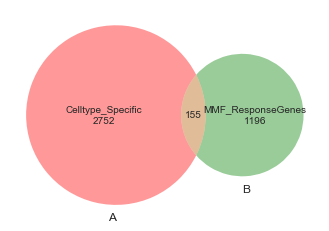

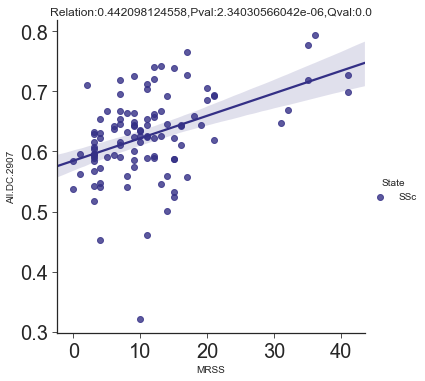

0
200
400


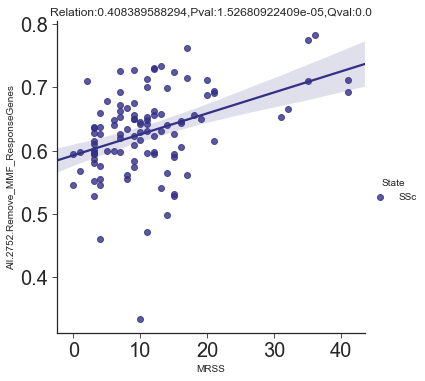

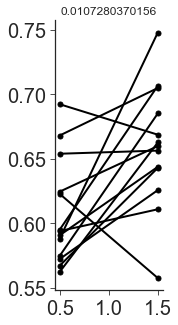

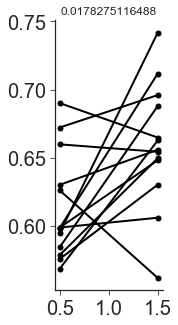

['Fib']
1583
1583
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


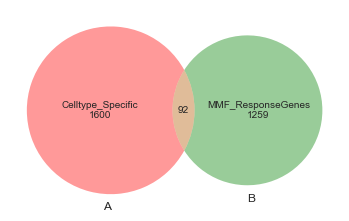

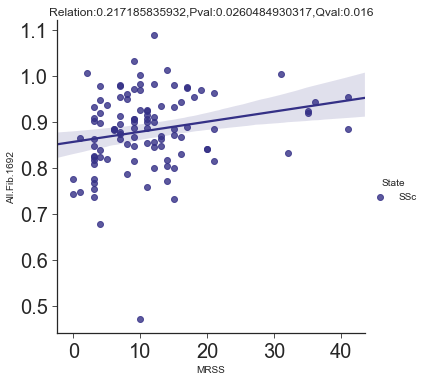

0
200
400


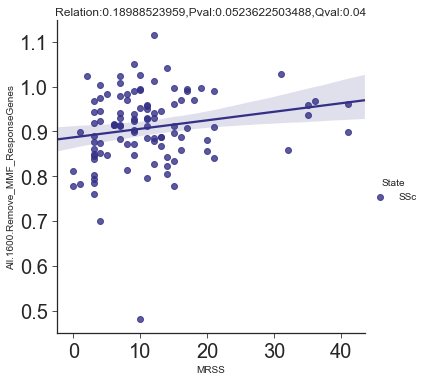

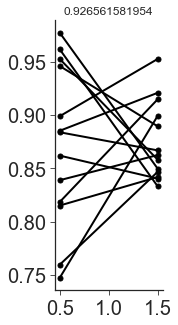

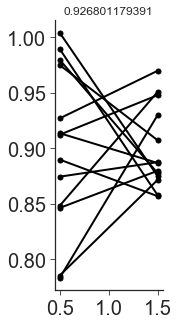

['LC']
182
182
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


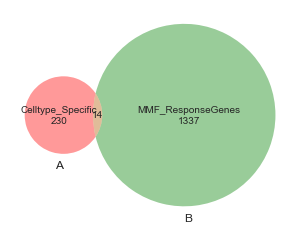

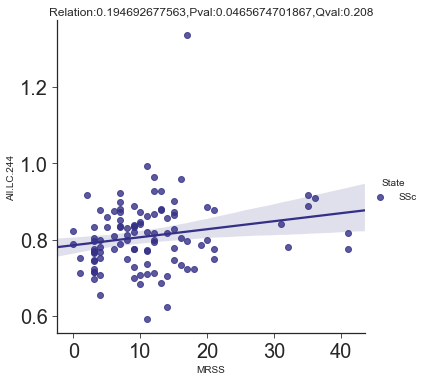

0
200
400


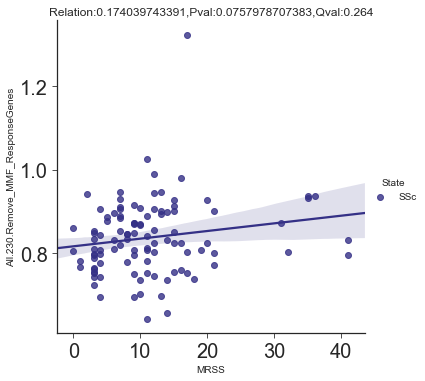

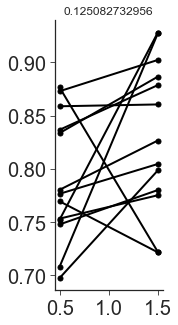

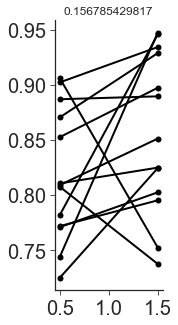

['EC']
941
941
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


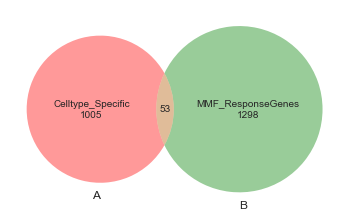

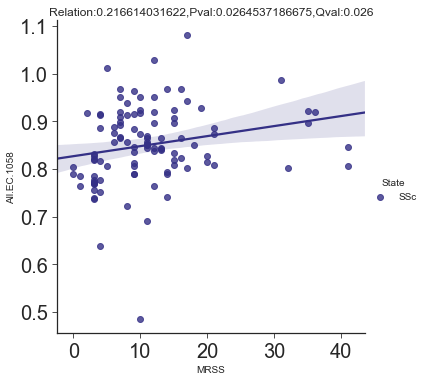

0
200
400


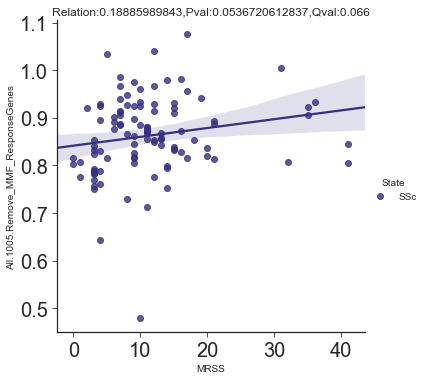

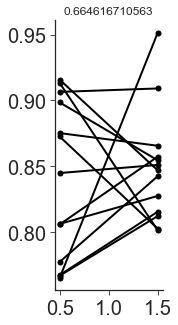

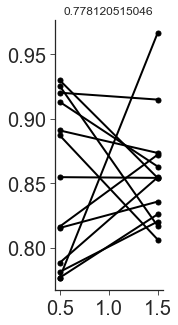

['CD4', 'CD4-CD8', 'CD8']
5795
5795
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


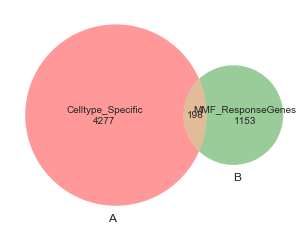

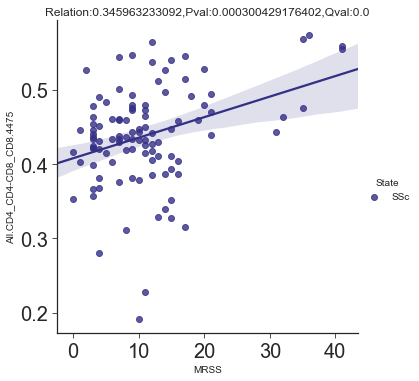

0
200
400


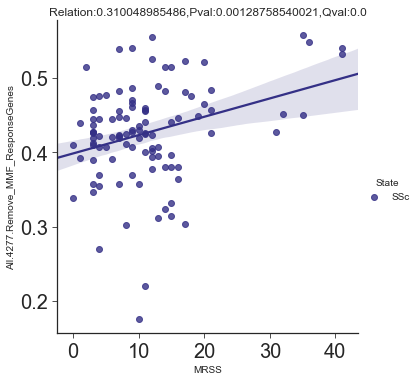

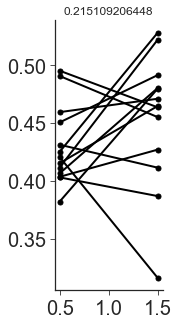

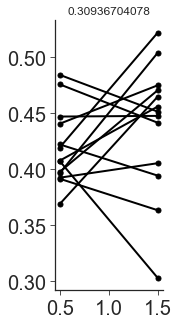

['KC']
1884
1884
[3, 4, 5, 6, 10, 16, 17, 21, 30, 33, 37, 42, 45]
0
200
400


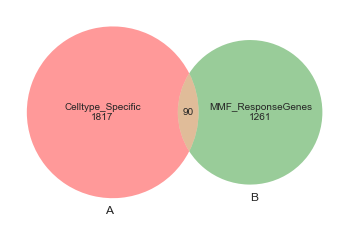

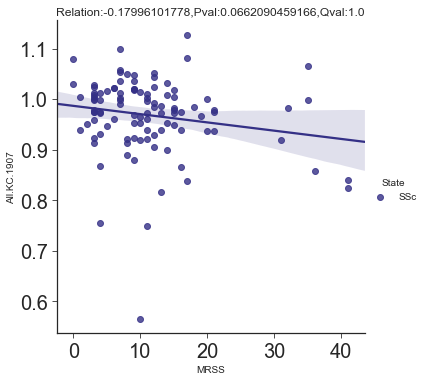

0
200
400


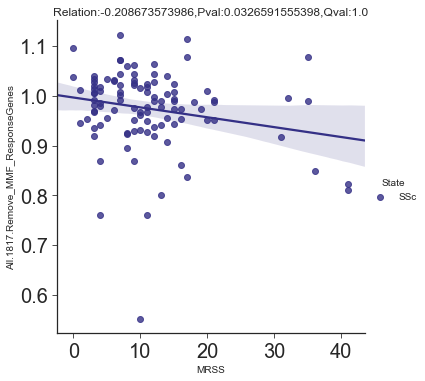

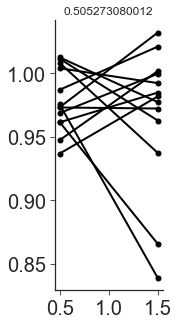

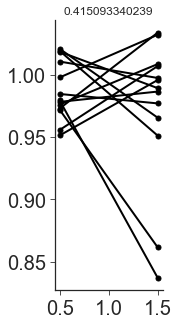

In [154]:
AllBedDF=ReadBed(AllBed)
for cts in [['DC'],['Fib'],['LC'],['EC'],['CD4','CD4-CD8','CD8'],['KC']]:   
    print cts
    GetSignatueGenes(DirAll,cts,'All.'+'_'.join(cts),AllBedDF,AllCellTypeSpecificPeaks_Dict, AllAnoDF )

Save(ClinicalDF, os.path.join(DirNorm,'CelltypeSignatureScore.txt')) 


